In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, subprocess
import warnings
import const
from datetime import datetime
from scipy.integrate import quad, quad_vec
from scipy.optimize import fsolve
from tabulate import tabulate



In [149]:
X, Y, Z = 0, 1, 2
ALPHA_EPS0P01, ALPHA_EPS0P1, ALPHA_EPS1P0, DMO, GAS = 0, 1, 2, 3, 4
HYDRO, DM, STAR = 0, 1, 2
epsilon = 1e-30

sim_idx = GAS


In [150]:
analysis_dir = "home/za9132/analysis"
sim_base_dir = "/home/za9132/scratch/romain"
sim_name = ["alpha_eps0p01", "alpha_eps0p1", "alpha_eps1p0", "dmo", "gas"][sim_idx]
sim_title = [r"$\varepsilon_{\rm SF} = 0.01$", r"$\varepsilon_{\rm SF} = 0.1$", r"$\varepsilon_{\rm SF} = 1.0$", "Dark Matter Only", "Multi-Freefall Model"][sim_idx]
sim_dir = os.path.join(sim_base_dir, sim_name)

os.chdir(sim_dir)


In [151]:
save_dir = os.path.join("/home/za9132/analysis/figures", sim_name)

def save_fig(name, filetype="png", dpi=300):
    '''
    Save the current matplotlib figure.
    
    Args
    name (string): figure name
    filetype (string): file type
    dpi (int): dots per inch
    '''
    datetime_string = datetime.now().strftime("%m%d%Y%H%M")
    filename = "%s-%s.%s" % (name, datetime_string, filetype)
    plt.savefig(os.path.join(save_dir, filename), bbox_inches="tight", dpi=dpi)
    print(filename)


In [152]:
def import_npz(npz_file):
    '''
    Import data from an npz file and add variables to global namespace.
    
    Args
    npz_file (string): npz file
    '''
    data = np.load(npz_file)
    for var_name in data:
        globals()[var_name] = data[var_name]


In [153]:
import_npz("gridded_data.npz")


In [154]:
coord1d = np.array([coord[X, :, N//2, N//2], coord[Y, N//2, :, N//2], coord[Z, N//2, N//2, :]])


In [155]:
def a_exp_to_proper_time(a):
    '''Convert expansion factor to proper time.'''
    integrand = lambda a: (Omega_m0 * a**(-1) + Omega_k0 + Omega_L0 * a**2)**(-1/2)
    t = quad(integrand, 0, a)[0] / H0
    
    return t

def a_exp_to_conformal_time(a):
    '''Convert expansion factor to conformal time.'''
    integrand = lambda a: (Omega_m0 * a + Omega_k0 * a**2 + Omega_L0 * a**4)**(-1/2)
    tau = const.c * quad(integrand, 0, a)[0] / H0
    
    return tau

def proper_time_to_a_exp(t):
    '''Convert proper time to expansion rate.'''
    a = fsolve(lambda a: (a_exp_to_proper_time(a) - t) * H0, a_exp)
    
    return a

def conformal_time_to_a_exp(tau):
    '''Convert conformal time to expansion rate.'''
    a = fsolve(lambda a: (a_exp_to_conformal_time(a) - tau) * H0, a_exp)
    
    return a


In [156]:
def plot_slice(field, extrema, slice=Z, project=False, weight=None, cond=None, avg=True, width=None, do_log=True, slice_coord=None, nlevels=200, cmap='jet', cbar_label='field', cbar_tick_increment=None, plot_star=False, plot_dm=False, isocontours=None):
    '''
    Plot a cross section of a field perpendicular to a coordinate axis.
    
    Args
    field: field
    extrema (tuple): tuple of min and max field value
    slice (int): index of the coordinate direction perpendicular to the slice plane
    project (bool): project the field along the slice direction
    weight: weight array to use for the project
    cond: conditional array to select a specific region for the projection
    avg (bool): take the average (rather than sum) in the projection
    width (float): width of plot
    do_log (bool): plot the log of the field
    slice_coord (float): coordinate of the cross section
    nlevels (int): number of levels in the contour plot
    cbar_label (string): colorbar label
    cbar_tick_increment (float): increment of the colorbar ticks
    plot_star (bool): plot markers for star particles within one cell of the cross section
    plot_dm (bool): plot markers for dark matter particles within one cell of the cross section
    isocontours: list of field values to plot isocontours
    '''
    if np.all(weight) == None: weight = 1.
    if np.all(cond) == None: cond = 1.
    
    if slice_coord == None:
        slice_coord = 0
        slice_coord_idx = N//2
    else:
        slice_coord_idx = np.argmin(np.abs(coord1d[slice] - slice_coord))
        
    if cbar_tick_increment == None: cbar_tick_increment = (extrema[1] - extrema[0]) / 10
        
    coord1_idx, coord2_idx = np.sort([(slice + 1) % 3, (slice + 2) % 3])
    
    coord12d = coord[coord1_idx].take(indices=slice_coord_idx, axis=slice)
    coord22d = coord[coord2_idx].take(indices=slice_coord_idx, axis=slice)

    if project:
        field2d = np.sum(field * weight * cond * dx, axis=slice)
        if avg: field2d /= np.sum(np.ones_like(field) * weight * cond * dx + epsilon, axis=slice)
    else:
        field2d = field.take(indices=slice_coord_idx, axis=slice)
        
    if do_log: 
        field2d = np.log10(field2d + epsilon)
        extrema = (np.log10(extrema[0]), np.log10(extrema[1]))
        if isocontours != None:
            isocontours = [np.log10(isocontour) for isocontour in isocontours]
            
    plt.contourf(coord12d / const.kpc, coord22d / const.kpc, field2d, extend='both', cmap=cmap, levels=np.linspace(extrema[0], extrema[1], nlevels))
    plt.gca().set_aspect(True)
    plt.colorbar(ticks=np.arange(extrema[0], extrema[1] + cbar_tick_increment, cbar_tick_increment), label=cbar_label)
    
    coord_labels = [r"$x$ [kpc]", r"$y$ [kpc]", r"$z$ [kpc]"]
    coord1_label, coord2_label = coord_labels[coord1_idx], coord_labels[coord2_idx]
    plt.xlabel(coord1_label); plt.ylabel(coord2_label)
    
    if width != None:
        plt.xlim(-width / const.kpc, width / const.kpc)
        plt.ylim(-width / const.kpc, width / const.kpc)
        
    if isocontours != None:
        plt.contour(coord1d2 / const.kpc, coord22d / const.kpc, field2d, levels=isocontours, colors='black', linewidths=2, linestyles='solid')
        
    if plot_star:
        
        in_slice_star = np.abs(star_coord[slice] - slice_coord) < dx
        plt.plot(star_coord[coord1_idx][in_slice_star] / const.kpc, star_coord[coord2_idx][in_slice_star] / const.kpc, marker='*', color='black', linestyle='')
            
    if plot_dm:
        
        in_slice_dm = np.abs(dm_coord[slice] - slice_coord) < dx
        plt.plot(dm_coord[coord1_idx][in_slice_dm] / const.kpc, dm_coord[coord2_idx][in_slice_dm] / const.kpc, marker='*', color='black', linestyle='')



In [157]:
def calc_radial_profile(field, r_lim=None, nbins=100, weight=None, cond=None):
    '''
    Compute radial profile of field averaged over spherical shells.
    
    Args
    field: field
    r_lim (float): maximum radius
    nbins (int): number of radial bins
    weight: weight array
    cond: conditional array to select a specific region
    
    Returns
    r_1d: array of radial bins
    field_1d: array of spherically averaged field values
    '''
    if (r_lim == None) or (r_lim > box_size * length_unit / 2):
        r_lim = box_size * length_unit / 2
    
    cond_sph = r < r_lim
    if np.all(cond) == None: cond = 1.
    if np.all(weight) == None: weight = 1.

    counts1, bins = np.histogram(r[cond_sph].flatten(), weights=(field * weight * cond)[cond_sph].flatten(), bins=nbins)
    counts2, bins = np.histogram(r[cond_sph].flatten(), weights=(np.ones_like(field) * weight * cond)[cond_sph].flatten(), bins=nbins)
    
    r_1d = bins[:-1] + np.diff(bins)[0]
    field_1d = counts1 / counts2
    
    return r_1d, field_1d


In [158]:
def calc_phase(field1, field2, extrema1, extrema2, do_log1=True, do_log2=True, cond=None, nbins=30):
    '''
    Compute distribution of mass in a two-dimensional phase space.
    
    Args
    field1, field2: fields
    extrema1, extrema2: tuples of max and min field values
    do_log1, do_log2 (bool): space bins logorithmically
    cond: conditional array to select a specific region
    nbins (int): number of bins
    
    Returns
    field1_2d, field2_2d: array of field bins
    mass_2d: array of mass per bin
    '''
    if do_log1: 
        field1 = np.log10(field1)
        extrema1 = (np.log10(extrema1[0]), np.log10(extrema1[1]))
    
    if do_log2:
        field2 = np.log10(field2)
        extrema2 = (np.log10(extrema2[0]), np.log10(extrema2[1]))
    
    if np.all(cond) == None: cond = 1.
    
    hist, x_bins, y_bins = np.histogram2d(field1.flatten(), field2.flatten(), weights=(density * dV * cond).flatten(), bins=nbins, range=[extrema1, extrema2])

    if do_log1:
        field1_2d = 10**(x_bins[:-1] + np.diff(x_bins)[0])
    else:
        field1_2d = x_bins[:-1] + np.diff(x_bins)[0]
        
    if do_log2:
        field2_2d = 10**(y_bins[:-1] + np.diff(y_bins)[0])
    else:
        field2_2d = y_bins[:-1] + np.diff(y_bins)[0]
        
    mass_2d = hist
    
    return field1_2d, field2_2d, mass_2d


In [159]:
def calc_mean(field, weight=None, cond=None):
    '''
    Calculate the mean value of a field
    
    Args
    field: field
    weight: weight array
    cond: conditional array to select a specific region
    
    Returns
    mean: mean value of the field
    '''
    if np.all(cond) == None: cond = 1.
    if np.all(weight) == None: weight = 1.
    
    mean = np.sum(field * weight * cond) / np.sum(np.ones_like(field) * weight * cond)
    
    return mean


In [160]:
def calc_contamination_frac(cond=None):
    '''
    Calculate the contamination fraction,
    defined as the mass fraction of dark matter particles above the minimum dark particle mass
    
    Args
    cond: conditional array to select a specific region
    
    Returns
    contamination_frac: contamination fraction
    '''
    if np.all(cond) == None: cond = np.ones_like(dm_mass)
    
    min_dm_mass = np.min(dm_mass[cond])
    cond_not_min_dm_mass = dm_mass > min_dm_mass
    
    contamination_frac = np.sum(dm_mass * cond * cond_not_min_dm_mass) / np.sum(dm_mass * cond)
    
    return contamination_frac


In [161]:
def calc_summary_stats(fields, names, weights, units, types, cond_hydro=None, cond_dm=None, cond_star=None):
    '''
    Calculate summary statistics for a region
    
    fields: list of fields to compute the min, max, and mean
    names: list of field names, must be the same length as fields
    weights: list of weights to use when computing field means, must be the same length as fields
    units: list of unit strings, must be the same length as fields
    types: list of field types (HYDRO, DM, STAR), must be the same length as fields
    cond_hydro: conditional array to select a specific region for hydro fields
    cond_dm: conditional array to select a specific region for dark matter fields
    cond_star: conditional array to select a specific region for star fields
    
    Returns
    summary_stats: dictionary of summary statistics
    '''
    for lst_name, lst in dict(names=names, weigts=weights, units=units, types=types).items():
        assert len(lst) == len(fields), "Length of %s list should match length of fields list" % lst_name
    
    summary_stats = {}
    
    for i, field in enumerate(fields):
        
        cond = [cond_hydro, cond_dm, cond_star][types[i]]
        
        if np.all(cond) == None: cond = np.ones_like(field)
        if units[i] == None: units[i] = ""
        
        min_field = np.min(field[cond])
        max_field = np.max(field[cond])
        mean_field = calc_mean(field, weight=weights[i], cond=cond)
        
        summary_stats[names[i]] = dict(min=min_field, max=max_field, mean=mean_field, unit=units[i])
        
    summary_stats["star part number"] = dict(min=0., max=0., mean=len(star_mass[cond_star]), unit="")
    summary_stats["dark matter part number"] = dict(min=0., max=0., mean=len(dm_mass[cond_dm]), unit="")
    summary_stats["contamination frac"] = dict(min=0., max=0., mean=calc_contamination_frac(cond=cond_dm), unit="")
    
    return summary_stats


In [162]:
def print_summary_stats(summary_stats):
    '''
    Print summary statistics in a nice table
    
    Args
    summary_stats: dictionary of summary statistics returned by calc_summary_stats()
    '''
    table = []
    
    for field, stats in summary_stats.items():
        
        table.append([field, "%.3g" % stats['max'], "%.3g" % stats['min'], "%.3g" % stats['mean'], stats['unit']])
    
    print(tabulate(table, headers=['Field', 'Max', 'Min', 'Mean', 'Unit']))
    

In [80]:
halo_radius = 5 * const.kpc
galaxy_radius = 0.1 * halo_radius

halo_region = (r < halo_radius)
galaxy_region = (r < galaxy_radius)

halo_region_dm = (r_dm < halo_radius)
galaxy_region_dm = (r_dm < galaxy_radius)

halo_region_star = (r_star < halo_radius)
galaxy_region_star = (r_star < galaxy_radius)


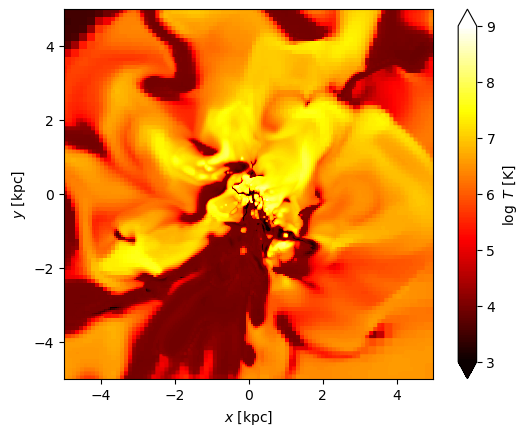

In [103]:
plot_xy_slice(temperature, (1e3, 1e9), slice=Z, do_log=True, cmap='hot', cbar_label=r'$\log~T$ [K]', cbar_tick_increment=1)

# save_fig("temp-xy")


metal-xy-092520231509.png


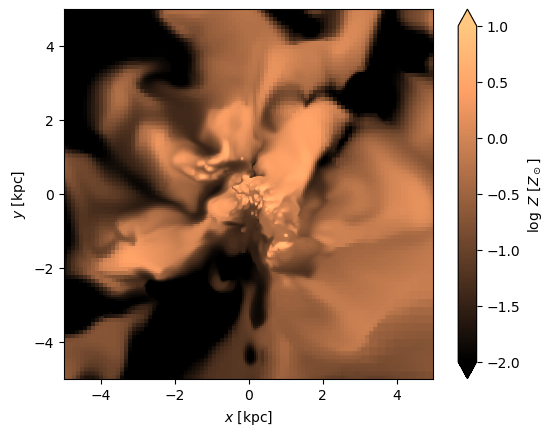

In [20]:
plot_xy_slice(metallicity / const.Z_sol, (1e-2, 1e1), do_log=True, cmap='copper', cbar_label=r'$\log~Z$ [$Z_\odot$]', cbar_tick_increment=0.5)

save_fig("metal-xy")


density-xy-092520231528.png


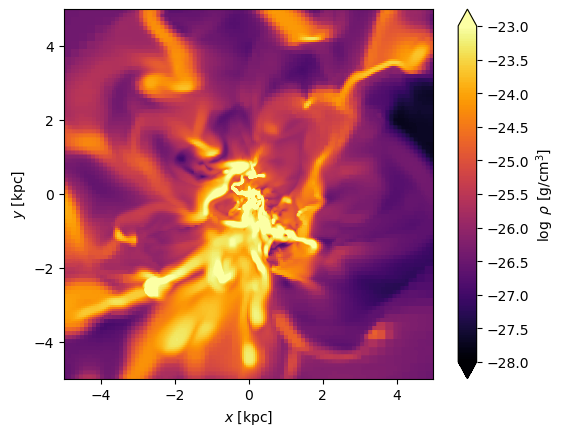

In [81]:
plot_xy_slice(density, (1e-28, 1e-23), do_log=True, cmap='inferno', cbar_label=r'$\log~\rho$ [${\rm g/cm^3}$]', cbar_tick_increment=0.5)

# save_fig("density-xy")


turb-xy-092520231509.png


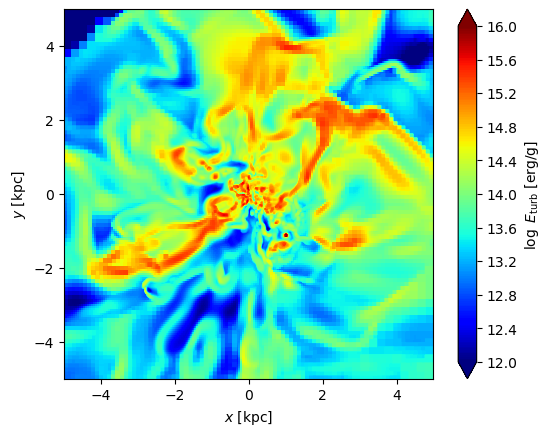

In [24]:
plot_xy_slice(turb_energy, (1e12, 1e16), do_log=True, cmap='jet', cbar_label=r'$\log~E_{\rm turb}$ [erg/g]', cbar_tick_increment=None)

save_fig("turb-xy")


refine-xy-092520231509.png


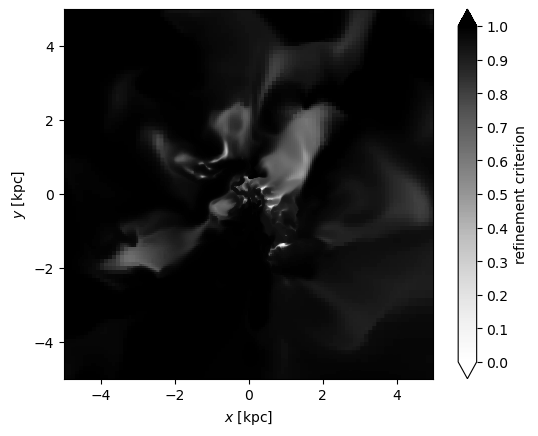

In [25]:
plot_xy_slice(refinement_criterion, (0, 1), do_log=False, cmap='Greys', cbar_label='refinement criterion', cbar_tick_increment=0.1)

save_fig("refine-xy")


stars-xy-092520231509.png


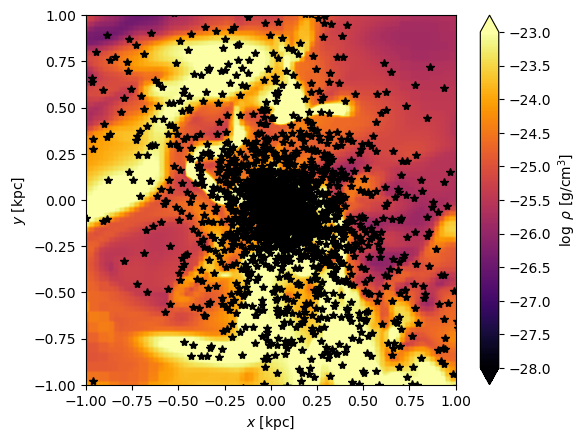

In [26]:
plot_xy_slice(density, (1e-28, 1e-23), width=1*const.kpc, do_log=True, cmap='inferno', cbar_label=r'$\log~\rho$ [${\rm g/cm^3}$]', cbar_tick_increment=0.5, plot_star=True)

save_fig("stars-xy")


In [68]:
n_H = density / const.m_p

n_H_2d, temperature_2d, mass_2d = calc_phase(n_H, temperature, (1e-4, 1e5), (1e1, 1e9), cond=(r < 2*const.kpc), nbins=50)


Text(0.5, 1.0, '$r < 2~{\\rm kpc}$')

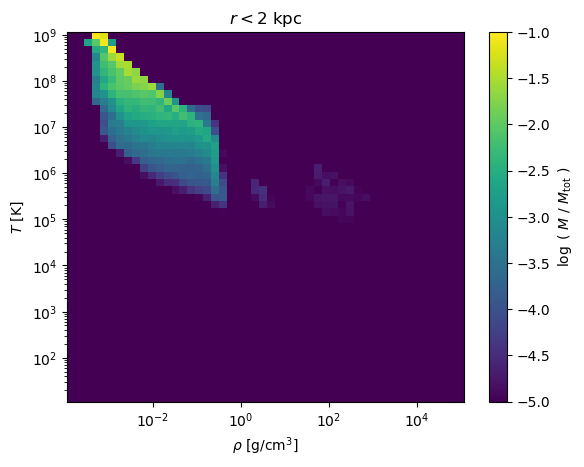

In [71]:
mass_frac_2d = mass_2d / np.sum(mass_2d)

plt.pcolor(n_H_2d, temperature_2d, np.log10(mass_frac_2d + epsilon), vmin=-5, vmax=-1)

plt.xlabel(r"$n_{\rm H}$ [${\rm cm^{-3}}$]")
plt.ylabel(r"$T$ [K]")

plt.xscale('log')
plt.yscale('log')

plt.colorbar(label=r'$\log~(~M~/~M_{\rm tot}~)$')

plt.title(r'$r < 2~{\rm kpc}$')

# save_fig("density-temp-phase")


In [72]:
r_1d, density_1d = calc_radial_profile(density, nbins=60)


density-1d-092520231527.png


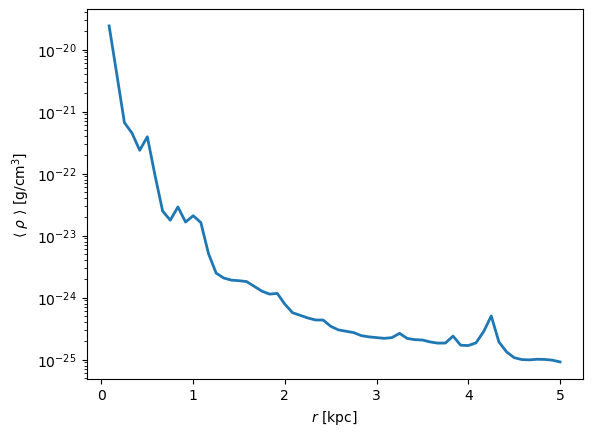

In [76]:
plt.plot(r_1d / const.kpc, density_1d, lw=2)

plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$\langle~\rho~\rangle$ [${\rm g/cm^3}$]')

plt.yscale('log')

save_fig("density-1d")


In [74]:
r_1d, temperature_1d = calc_radial_profile(temperature, weight=density, nbins=60)


temperature-1d-092520231527.png


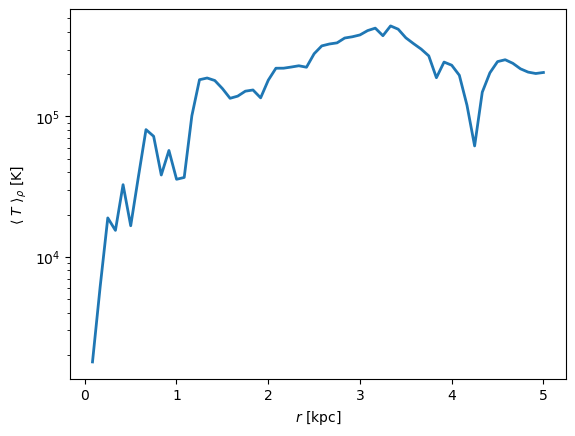

In [77]:
plt.plot(r_1d / const.kpc, temperature_1d, lw=2)

plt.xlabel(r'$r$ [kpc]')
plt.ylabel(r'$\langle~T~\rangle_\rho$ [K]')

plt.yscale('log')

save_fig("temperature-1d")


Text(0.5, 0, 'Star Age [Myr]')

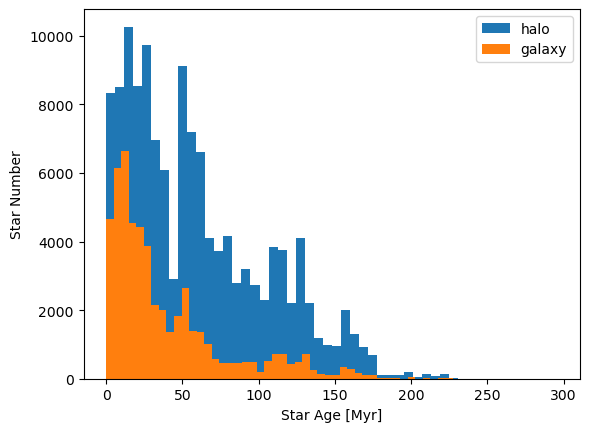

In [78]:
nbins = 50

star_age = current_time - star_birth_time

plt.hist(star_age[halo_region_star] / const.Myr, bins=nbins, label='halo')
plt.hist(star_age[galaxy_region_star] / const.Myr, bins=nbins, label='galaxy')

plt.legend()

plt.ylabel("Star Number")
plt.xlabel("Star Age [Myr]")

# save_fig("star-ages")


Text(0.5, 0, 'Star Mass [$M_\\odot$]')

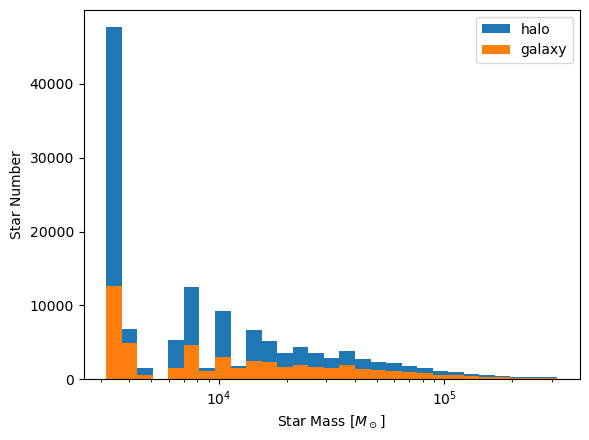

In [141]:
nbins = np.logspace(3.5, 5.5, 30)

star_age = current_time - star_birth_time

plt.hist(star_mass[halo_region_star] / const.M_sol, bins=nbins, label='halo')
plt.hist(star_mass[galaxy_region_star] / const.M_sol, bins=nbins, label='galaxy')

plt.legend()

plt.xscale('log')

plt.ylabel("Star Number")
plt.xlabel("Star Mass [$M_\odot$]")


Text(0.5, 0, '$t$ [Myr]')

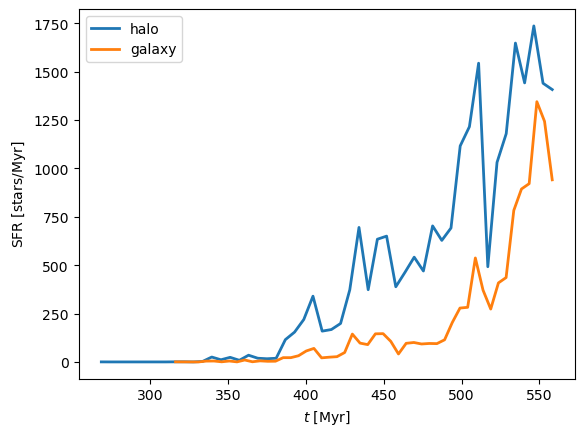

In [142]:
nbins = 50

for region_name, region_star in zip(["halo", "galaxy"], [halo_region_star, galaxy_region_star]):

    counts, bins = np.histogram(star_birth_time[region_star] / const.Myr, bins=nbins)

    star_birth_time_1d = bins[:-1] + np.diff(bins)[0]
    star_number_1d = counts
    SFR_1d = star_number_1d / np.diff(bins)[0]

    plt.plot(star_birth_time_1d, SFR_1d, lw=2, label=region_name)

plt.legend()

plt.ylabel(r"SFR [${\rm stars / Myr}$]")
plt.xlabel(r"$t$ [Myr]")


Text(0.5, 0, '$t$ [Myr]')

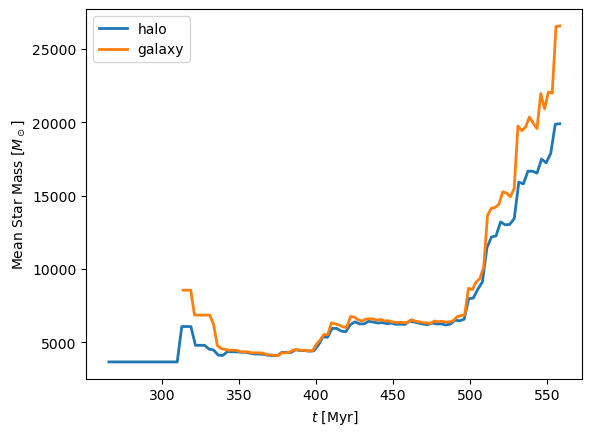

In [143]:
nbins = 100

for region_name, region_star in zip(["halo", "galaxy"], [halo_region_star, galaxy_region_star]):

    counts_number, bins = np.histogram(star_birth_time[region_star] / const.Myr, bins=nbins)
    counts_mass, bins = np.histogram(star_birth_time[region_star] / const.Myr, bins=nbins, weights=star_mass[region_star])
    
    star_birth_time_1d = bins[:-1] + np.diff(bins)[0]
    star_number_1d = counts_number
    star_mass_1d = counts_mass
    cum_star_number_1d = np.cumsum(star_number_1d)
    cum_star_mass_1d = np.cumsum(star_mass_1d)
    mean_star_mass_1d = cum_star_mass_1d / cum_star_number_1d

    plt.plot(star_birth_time_1d, mean_star_mass_1d / const.M_sol, lw=2, label=region_name)

plt.legend()

plt.ylabel(r"Mean Star Mass [$M_\odot$]")
plt.xlabel(r"$t$ [Myr]")


In [45]:
star_age = current_time - star_birth_time

stats = {
    'fields': [density, temperature, metallicity / const.Z_sol, star_mass / const.M_sol, star_age / const.Myr, dm_mass / const.M_sol],
    'names': ["density", "temperature", "metallicity", "star mass", "star age", "dark matter mass"],
    'units': ["g/cm^3", "K", "Z_sol", "M_sol", "Myr", "M_sol"],
    'weights': [None, density, density, None, None, None],
    'types': [HYDRO, HYDRO, HYDRO, STAR, STAR, DM]
}

halo_stats = calc_summary_stats(cond_hydro=halo_region, cond_dm=halo_region_dm, cond_star=halo_region_star, **stats)
galaxy_stats = calc_summary_stats(cond_hydro=galaxy_region, cond_dm=galaxy_region_dm, cond_star=galaxy_region_star, **stats)


In [46]:
print('Halo Summary Stats')
print_summary_stats(halo_stats)
print("\n")

print('Galaxy Summary Stats')
print_summary_stats(galaxy_stats)
print("\n")


Halo Summary Stats
Field                              Max           Min           Mean  Unit
-----------------------  -------------  ------------  -------------  ------
density                       3.06e-18      2.09e-29       1.14e-24  g/cm^3
temperature                   4.04e+08     10.1        69500         K
metallicity                   7.85          0.00149        0.334     Z_sol
star mass                485000          3180          19900         M_sol
star age                    296             0.0526        59.5       Myr
dark matter mass         163000         20400          20400         M_sol
star part number              0             0         132000
dark matter part number       0             0              1.5e+06
contamination frac            0             0              4.82e-05


Galaxy Summary Stats
Field                              Max           Min          Mean  Unit
-----------------------  -------------  ------------  ------------  ------
density            

## Replicate Romain Plots

In [163]:
romain_box = 2*const.kpc
cond_romain = (np.abs(coord[X]) < romain_box/2) * (np.abs(coord[Y]) < romain_box/2) * (np.abs(coord[Z]) < romain_box/2)
cond_romain_star = (np.abs(star_coord[X]) < romain_box/2) * (np.abs(star_coord[Y]) < romain_box/2) * (np.abs(star_coord[Z]) < romain_box/2)


In [135]:
n_H = density / const.m_p

n_H_2d, temperature_2d, mass_2d = calc_phase(n_H, temperature, (1e-4, 1e5), (1e1, 1e9), cond=cond_romain, nbins=50)


Text(0.5, 1.0, '$|x|, |y|, |z| < 1~{\\rm kpc}$')

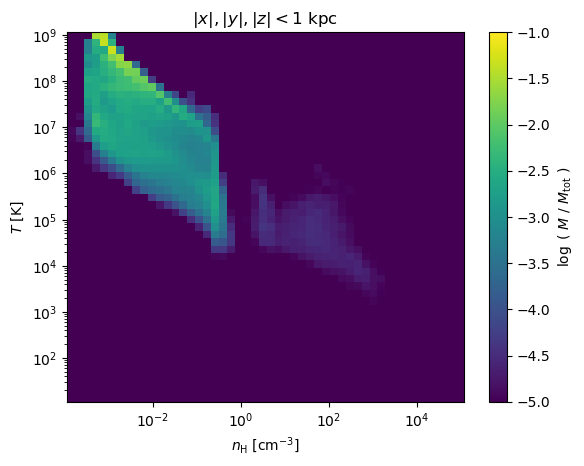

In [148]:
mass_frac_2d = mass_2d / np.sum(density[cond_romain] * dV)

plt.pcolor(n_H_2d, temperature_2d, np.log10(mass_frac_2d + epsilon), vmin=-5, vmax=-1)

plt.xlabel(r"$n_{\rm H}$ [${\rm cm^{-3}}$]")
plt.ylabel(r"$T$ [K]")

plt.xscale('log')
plt.yscale('log')

plt.colorbar(label=r'$\log~(~M~/~M_{\rm tot}~)$')

plt.title(r'$|x|, |y|, |z| < 1~{\rm kpc}$')

# save_fig("density-temp-phase")

Text(0.5, 1.0, '$|x| < 1~{\\rm kpc}$')

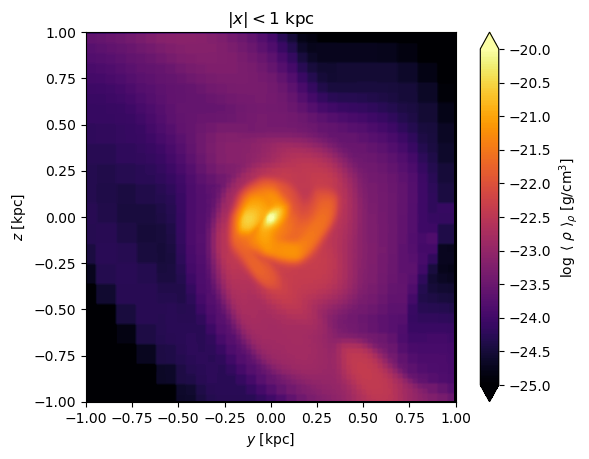

In [165]:
plot_slice(density, (1e-25, 1e-20), width=romain_box/2, avg=True, slice=X, weight=density, cond=cond_romain, project=True, do_log=True, cmap='inferno', cbar_label=r'$\log~\langle~\rho~\rangle_\rho$ [${\rm g/cm^3}$]', cbar_tick_increment=0.5)

plt.title(r'$|x| < 1~{\rm kpc}$')

# save_fig("density-xy")


Text(0.5, 1.0, '$|x|, |y|, |z| < 1~{\\rm kpc}$')

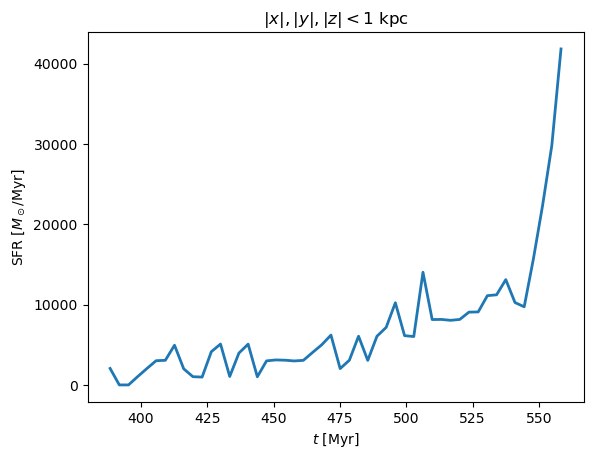

In [164]:
nbins = 50

counts, bins = np.histogram(star_birth_time[cond_romain_star] / const.Myr, bins=nbins, weights=star_mass[cond_romain_star])

star_birth_time_1d = bins[:-1] + np.diff(bins)[0]
star_mass_1d = counts
SFR_mass_1d = star_mass_1d / np.diff(bins)[0]

plt.plot(star_birth_time_1d, SFR_mass_1d / const.M_sol, lw=2)

plt.ylabel(r"SFR [$M_\odot / {\rm Myr}$]")
plt.xlabel(r"$t$ [Myr]")

plt.title(r'$|x|, |y|, |z| < 1~{\rm kpc}$')
